In [1]:



#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@文件        :AC_Fourier_t1_20241207_w12_s.ipynb
@说明        :这个文件中，w12训练,s不训练
@时间        :2024/12/07 19:10:38
@作者        :zhangyushi23@gscaep.ac.cn
@版本        :1.0
'''




#导入torch，用于构建神经网络

import torch
from torch import nn


import numpy as np
import pandas as pd

#记录时间
from datetime import datetime

import time


import matplotlib.pyplot as plt

from scipy.interpolate import griddata
import scipy.io


#用于重复独立实验的随机种子
import random


#获取当前文件的名称

import os



plt.rcParams['figure.dpi'] =200




In [2]:


# %%

#设置随机种子
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False# 尝试禁用这两个数据类型
        torch.backends.cudnn.allow_tf32 = False
        #torch.backends.cudnn.deterministic = True
        #torch.backends.cudnn.benchmark = False

        



        


In [3]:
def sample(min,max, N):

    x = min + (max - min) * torch.rand((N, 1), dtype = datadtype).to(device).requires_grad_(True)
   
    return x




In [4]:

class Net(nn.Module):
    def __init__(self,datadtype,layers):
        super().__init__()
        self.dtype = datadtype

        self.layers = layers

      

        # #定义傅里叶特征的系数
 
        self.W_t = nn.Parameter(torch.randn(1,self.layers[0]//2,
                                            dtype = self.dtype)*sigma_t,requires_grad = False).to(device)
        
        self.W_x = nn.Parameter(torch.randn(1,layers[0]//2,
                                            dtype = self.dtype)*sigma_x,requires_grad = False).to(device)

        self.weights, self.biases = self.initialize_NN(self.layers)

    def xavier_init(self,size):
        in_dim = size[0]
        out_dim = size[1]
        #创建一个需要Xavier初始化的张量
        tensor = torch.empty(in_dim, out_dim, dtype = self.dtype).to(device)
        #使用PyTorch的Xavier正态初始化
        nn.init.xavier_normal_(tensor)
        return tensor
    
    def initialize_NN(self, layers):
        weights = nn.ParameterList()
        biases = nn.ParameterList()

        num_layers = len(layers)
        for l in range(0, num_layers -2):
            W = self.xavier_init(size = [layers[l], layers[l+1]])
            b = nn.Parameter(torch.randn(1, layers[l+1],dtype = self.dtype)).to(device)

            weights.append(W)
            biases.append(b)

        W = self.xavier_init(size = [layers[-2], layers[-1]])
        b = nn.Parameter(torch.randn(1, layers[-1], dtype = self.dtype)).to(device)
        weights.append(W)
        biases.append(b)

        return weights, biases
    
    def forward(self,t,x):
        num_layers = len(self.layers)
        
        # t = (t - t_lb)/(t_ub - t_lb)
        # x = (x - x_min)/(x_max - x_min) 

        #Temporal Fourier feature encoding
        H_t = torch.cat([torch.sin(torch.matmul(t, self.W_t)).to(device),
                         torch.cos(torch.matmul(t, self.W_t)).to(device)], dim = 1).to(device)
        
        #Spatial Fourier feature encoding
        H_x = torch.cat([torch.sin(torch.matmul(x, self.W_x)).to(device),
                         torch.cos(torch.matmul(x, self.W_x)).to(device)], dim = 1).to(device)
        
        #Pass through a MLP
        for l in range(0, num_layers -2):
            W = self.weights[l]
            b = self.biases[l]
            H_t = torch.tanh(torch.add(torch.matmul(H_t, W), b))
            H_x = torch.tanh(torch.add(torch.matmul(H_x, W), b))

        #Merge the outputs via points-wise multiplication
        H = H_t * H_x

        W = self.weights[-1]
        b = self.biases[-1]
        H = torch.add(torch.matmul(H, W), b)
        return H

In [5]:


# %%

class HCPINN(nn.Module):
    def __init__(self,mydtype, layers,  t_min,t_max):
        
        super(HCPINN, self).__init__()
        self.dtype = mydtype
        self.layers = layers

        self.t_min = t_min
        self.t_max = t_max



   
        #采点
        self.N_i = 1200
        self.N_b = int(1200 * (self.t_max - self.t_min))
        self.eta = 0.6
        self.N_r = int(1e4 * (self.t_max - self.t_min))
        self.N_n = int(self.N_r * self.eta )
        
        self.t_ics_batch =  sample(self.t_min,self.t_min, self.N_i)
        self.x_ics_batch =  sample(x_min,x_max, self.N_i)
       

        
        self.t_bc1_batch =  sample(self.t_min,self.t_max, self.N_b)
        self.x_bc1_batch =  sample(x_min,x_min, self.N_b)
        


        
        self.x_bc2_batch =  sample(x_max,x_max, self.N_b)
        


        #Fetch residual mini-bathes
        
        self.t_res_batch =  sample(self.t_min,self.t_max, self.N_r)
        self.x_res_batch =  sample(x_min,x_max, self.N_r)
       


        self.u_ics_batch = initial(self.x_ics_batch)



        #定义优化器
        self.net = Net(self.dtype, self.layers).to(device)
        self.iter = 0
        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, step_size = 1000, gamma= 0.9)
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),
            lr = 1.0,
            max_iter = 10000,
            max_eval = 50000,
            history_size = 200,
            tolerance_grad = 1e-12,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )




    
  
    
    def net_u(self, t,x):
        u = self.net(t,x)
        return u
    
    def net_r(self, t, x):

     
        u = self.net_u(t,x)
       

        u_t = torch.autograd.grad(u, t,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]

        u_xx = torch.autograd.grad(u_x, x,
                                  grad_outputs=torch.ones_like(u_x),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
      

        residual =  u_t - 0.0001* u_xx + 5*u**3-5*u                     
        return residual
    
    def net_b(self, t, x):

     
        u = self.net_u(t,x)
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        

        return u_x


    
    def closure(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()



        #Evaluate predictions
        
      
        self.u_ics_pred = self.net_u(self.t_ics_batch, self.x_ics_batch)
        self.u_bc1_pred = self.net_u(self.t_bc1_batch, self.x_bc1_batch)
        self.u_bc2_pred = self.net_u(self.t_bc1_batch, self.x_bc2_batch)
        self.ux_bc1_pred = self.net_b(self.t_bc1_batch, self.x_bc1_batch)
        self.ux_bc2_pred = self.net_b(self.t_bc1_batch, self.x_bc2_batch)

     
        self.r_pred = self.net_r(self.t_res_batch, self.x_res_batch)

        #Boundary loss and Initial loss
        self.loss_ic = torch.mean((self.u_ics_pred- self.u_ics_batch)**2 )

        self.loss_ics = self.loss_ic


        self.loss_bc1 = torch.mean((self.u_bc1_pred - self.u_bc2_pred)**2 )
        self.loss_bc2 = torch.mean((self.ux_bc1_pred -self.ux_bc2_pred)**2 )

        self.loss_bcs = self.loss_bc2 + self.loss_bc1
        

        #Residual loss
        self.loss_res = torch.mean((self.r_pred)**2 )

        #Total loss
        self.loss =  100*self.loss_ics + self.loss_bcs + self.loss_res 

        self.loss.backward(retain_graph=True)
        

        self.iter += 1

        



        if self.iter % 1000 == 0:
            print(f'\r{self.iter},loss:{self.loss.item():.5e},i:{self.loss_ics.item():.2e},f:{self.loss_res.item():.2e},b:{self.loss_bcs.item():.2e}')
            if self.iter < nIter:
            
                # 生成随机索引
                shuffle_indices = torch.randperm(self.N_r, device = device)

                x_new_train = sample(x_min,x_max, self.N_n)

                # 打乱张量顺序
                self.x_res_batch = self.x_res_batch[shuffle_indices]

                self.x_res_batch[0:self.N_n] = x_new_train

                t_new_train = sample(self.t_min,self.t_max, self.N_n)

                # 打乱张量顺序
                self.t_res_batch = self.t_res_batch[shuffle_indices]

                self.t_res_batch[0:self.N_n] = t_new_train

        # if self.iter < nIter and self.iter % 1000 == 0:

        #         # 生成随机索引
        #         shuffle_indices = torch.randperm(N_r, device = device)

        #         x_new_train = sample(x_min,x_max, N_n)

        #         # 打乱张量顺序
        #         self.x_res_batch = self.x_res_batch[shuffle_indices]

        #         self.x_res_batch[0:N_n] = x_new_train

        #         t_new_train = sample(self.t_min,self.t_max, N_n)

        #         # 打乱张量顺序
        #         self.t_res_batch = self.t_res_batch[shuffle_indices]

        #         self.t_res_batch[0:N_n] = t_new_train



        return self.loss
    
    def predict_u(self,X):
        t = X[:,0:1]
        x = X[:,1:2]
        #模型进入评估状态
        self.eval()
        with torch.no_grad():
            u = self.net_u(t,x).detach()
 
        return u
    




In [6]:

# %%


class HCPINN_next(nn.Module):
    def __init__(self,mydtype, layers,t_min,t_max, premodel):
        
        super(HCPINN_next, self).__init__()
        

        self.premodel = premodel
        self.pre_net =  self.premodel.net
        self.dtype = mydtype

        self.t_min = t_min
        self.t_max = t_max

        #停止第一个网络参数的训练
        for param in self.premodel.parameters():
            param.requires_grad = False

      

 

        #Initialize network weights and biases
        self.layers = layers
      

        

        
        
        #采点
        self.N_i = 100
        self.N_b = int(1200 * (self.t_max - self.t_min))
        self.N_r = int(1e4 * (self.t_max - self.t_min))
        self.eta = 0.6
        self.N_n = int(self.eta * self.N_r)


       
        self.t_ics_batch =  sample(self.t_min,self.t_min, self.N_i)
        self.x_ics_batch =  sample(x_min,x_max, self.N_i)
        

        
        self.t_bc1_batch =  sample(self.t_min,self.t_max, self.N_b)
        self.x_bc1_batch =  sample(x_min,x_min, self.N_b)
       

        self.x_bc2_batch =  sample(x_max,x_max, self.N_b)
        

        #Fetch residual mini-bathes
        
        self.t_res_batch =  sample(self.t_min,self.t_max, self.N_r)
        self.x_res_batch =  sample(x_min,x_max, self.N_r)
        


        
        self.u_ics_batch = self.premodel.net_u(self.t_ics_batch, self.x_ics_batch)


   


        #将分段函数加入训练
        #定义第一个控制函数
        self.param_log = []
      
    
        self.w1 =  self.t_min + (self.t_max-self.t_min) * 0.8
        

        print("p的初始化%.3e "%(self.w1.item()))


        #定义优化器
        self.iter = 0
        self.net = Net(self.dtype, self.layers).to(device)

        self.adam = torch.optim.Adam(self.parameters(), lr = 1e-3)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.adam, step_size= 1000, gamma= 0.9)
        self.optimizer = torch.optim.LBFGS(
            self.parameters(),#间断点在LBFGS的阶段也训练
            lr = 1.0,
            max_iter = 10000,
            max_eval = 50000,
            history_size = 200,
            tolerance_grad = 1e-12,
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = 'strong_wolfe'
        )


        # # #加载上一个网络的信息
        # self.pretrained_dict = self.premodel.net.state_dict()
        # model_dict = self.net.state_dict()
        # model_dict.update(self.pretrained_dict)
        # self.net.load_state_dict(model_dict)
        # self.net.state_dict()


    
    def impact_func(self,t):
        ab = self.w1
        # 条件1: t <= 0.5
        condition2 = t <= self.t_min
        # 条件3: t <= ab
        condition3 = t <= ab
        # 条件4: ab <= 1
        condition4 = ab <= self.t_max

        # 计算 B 和 BB
        BB = (t - self.t_min)/ (self.t_max - self.t_min)
        B = (t - self.t_min) / (ab - self.t_min)


        result = torch.where(condition2, torch.zeros_like(t),
                        torch.where(condition4, 
                                    torch.where(condition3, -2 * B**3 + 3 * B**2, torch.zeros_like(t) + 1),torch.where(condition3, -2 * BB**3 + 3 * BB**2, torch.zeros_like(t) + 1)))
                                   
        
       
        

        return result
    
  
    



    def net_u(self, t,x):
        ww = self.impact_func(t)
        u =  (1-ww)*self.pre_net(t,x) + ww* self.net(t,x)
        return u
    
  
    
    def net_r(self, t, x):

        u = self.net_u(t,x)

        u_t = torch.autograd.grad(u, t,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]

        u_xx = torch.autograd.grad(u_x, x,
                                  grad_outputs=torch.ones_like(u_x),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
        

        residual = u_t - 0.0001* u_xx + 5*u**3-5*u   

                             
        return residual
    
    def net_b(self, t, x):

        u = self.net_u(t,x)

        
        u_x = torch.autograd.grad(u, x,
                                  grad_outputs=torch.ones_like(u),
                                  create_graph= True,
                                  retain_graph=True)[0]
        
       
        return u_x


    
    def closure(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        #self.w1.data = torch.clamp(self.w1.data, (self.t_min+(self.t_max-self.t_min)*0.5).item(), (self.t_min+(self.t_max-self.t_min)*1.0).item())
       
        #Evaluate predictions
        
       

        self.u_ics_pred = self.net_u(self.t_ics_batch, self.x_ics_batch)
        self.u_bc1_pred = self.net_u(self.t_bc1_batch, self.x_bc1_batch)
        self.u_bc2_pred = self.net_u(self.t_bc1_batch, self.x_bc2_batch)
        self.ux_bc1_pred = self.net_b(self.t_bc1_batch, self.x_bc1_batch)
        self.ux_bc2_pred = self.net_b(self.t_bc1_batch, self.x_bc2_batch)

     
        self.r_pred = self.net_r(self.t_res_batch, self.x_res_batch)

        #Boundary loss and Initial loss
        self.loss_ic = torch.mean((self.u_ics_pred- self.u_ics_batch)**2 )
        self.loss_bc1 = torch.mean((self.u_bc1_pred - self.u_bc2_pred)**2 )
        self.loss_bc2 = torch.mean((self.ux_bc1_pred -self.ux_bc2_pred)**2 )

        self.loss_bcs = self.loss_bc2 + self.loss_bc1
        self.loss_ics = self.loss_ic

        #Residual loss
        self.loss_res = torch.mean((self.r_pred)**2 )

        #Total loss
        self.loss = self.loss_bcs + self.loss_res

        self.loss.backward(retain_graph=True)
        

        self.iter += 1

        
        
        self.param_log.append([self.w1.item()])
 

        if self.iter % 1000 == 0:
            print(f'\r{self.iter},loss:{self.loss.item():.5e},i:{self.loss_ics.item():.2e},f:{self.loss_res.item():.2e},b:{self.loss_bcs.item():.2e},p:{self.w1.item():.2e}')
           
            
            if self.iter < nIter :
                # 生成随机索引
            
                shuffle_indices = torch.randperm(self.N_r, device = device)

                x_new_train = sample(x_min,x_max, self.N_n)

                

                # 打乱张量顺序
                self.x_res_batch = self.x_res_batch[shuffle_indices]

                self.x_res_batch[0:self.N_n] = x_new_train

                t_new_train = sample(self.t_min,self.t_max,self.N_n)

                # 打乱张量顺序
                self.t_res_batch = self.t_res_batch[shuffle_indices]

                self.t_res_batch[0:self.N_n] = t_new_train


        # if self.iter < nIter and self.iter % 1000 == 0:

        #                 # 生成随机索引
        #                 shuffle_indices = torch.randperm(N_r, device = device)

        #                 x_new_train = sample(x_min,x_max, N_n)

        #                 # 打乱张量顺序
        #                 self.x_res_batch = self.x_res_batch[shuffle_indices]

        #                 self.x_res_batch[0:N_n] = x_new_train

        #                 t_new_train = sample(self.t_min,self.t_max, N_n)

        #                 # 打乱张量顺序
        #                 self.t_res_batch = self.t_res_batch[shuffle_indices]

        #                 self.t_res_batch[0:N_n] = t_new_train

        return self.loss
    
    def predict_u(self,X):
        t = X[:,0:1]
        x = X[:,1:2]
        self.eval()
        with torch.no_grad():
            u = self.net_u(t,x).detach()
            
        return u
    




In [7]:



# %%

# %%
#Define initial condition 

def initial(x):

   
    u = x ** 2 * torch.cos(torch.pi * x)
    return u



In [8]:


# %%

# %%

# %%
#画出区间的图像以及求误差
def plot_error_block(model,t_min,t_max):
   
    n_min = int(t_min * num_points)
    n_max = int(t_max * num_points)
    #n_test = n_max - n_min

    t_block = t_total[n_min:n_max +1]
    T_block, X_block = torch.meshgrid(t_block, x_total, indexing='ij')

    #组装
 
    X_star_block = torch.cat((T_block.flatten()[:, None], X_block.flatten()[:,None]), dim=1)

    #引入真实的信息
    u0_star = data[:,n_min:n_max +1].T
    u_star = u0_star.flatten()[:,None]

    #网络预测的结果
    u_pred_block = model.predict_u(X_star_block)

    #计算误差
    error_u =  torch.norm(u_star - u_pred_block, p=2) /torch.norm(u_star, p=2)
    error_u1 = torch.norm(u_star - u_pred_block, p=1) / len(X_star_block)
    error_uinf = torch.norm(u_star - u_pred_block, p=float('inf'))
    
    print("\n查看区间：[%.2f,%.2f]"%(T_block.min().item(), T_block.max().item()))
    print("\nRelative L2 error_u: {:.5e}".format(error_u))
    print("\nRelative L1 error_u: {:.5e}".format(error_u1))
    print("\nRelative Linf error_u: {:.5e}".format(error_uinf))
    


    return u_pred_block, error_u.item(), error_u1.item(), error_uinf.item()



In [9]:
def plot_func(t, func1,p_log):
    fig = plt.figure(figsize=(15, 3),dpi=200)
    plt.subplot(1, 2, 1)
    plt.plot(t.cpu().detach().numpy(), func1(t).cpu().detach().numpy())
    plt.title("eta(t)")


    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(p_log)), p_log)
    plt.title("p_log")
    plt.show()
   

In [10]:


def train_block(t_min, t_max, num_block,train_num):
    train_time = 0
    models = []
    error_total = []
   
    t_block = torch.linspace(t_min, t_max, num_block + 1).to(device)

    train_time_total = []
    for i in range(num_block):
        
        print('训练区间：[%.2f,%.2f]'%(t_block[i], t_block[i+1]))

        
        if i == 0:
            
            model = HCPINN(datadtype,layers, t_block[i],t_block[i+1])

                #进行训练
            start_time = time.time()
            print('\n\t====Begin Adam====')
            for adam_iter in range(nIter):
                    model.closure()
                    model.adam.step()
                    model.scheduler.step()
            print('\n\t====Begin LBFSG====')
            model.optimizer.step(model.closure)
            block_time =  (time.time() - start_time)/60
            
          


        else:

            model = HCPINN_next(datadtype, layers,t_block[i], t_block[i+1],   models[-1])



            #进行训练
            start_time = time.time()
            print('\n\t====Begin Adam====')
            for adam_iter in range(nIter):
                    model.closure()
                    model.adam.step()
                    model.scheduler.step()
            print('\n\t====Begin LBFSG====')
            model.optimizer.step(model.closure)
            block_time =  (time.time() - start_time)/60

            #画出铰链函数
            plot_func(torch.linspace(t_min, t_max + 0.1, 10000).to(device), model.impact_func,model.param_log)
            
           

            
            #保存当前参数的变化
            df_param_log = pd.DataFrame(model.param_log, columns=['p'])

         

            # 将DataFrame保存为Excel文件
            df_param_log.to_excel(folder_path + "/第%d次训练_[%.2f,%.2f]_p_log.xlsx"%(train_num, t_block[i],t_block[i+1]), index=False)

     

          
        
        train_time_total.append(block_time)
        print('区间[%.2f,%.2f]的训练时间：%.2f min(s)'%(t_block[i],t_block[i+1] ,(time.time() - start_time) /60)) 
        print("Final loss: %.5e,Total iteration: %d"%(model.loss.item(),model.iter))

        
        
        #保存网络
        torch.save(model.state_dict(),folder_path + "/第%d次训练_[%.2f,%.2f].pth"%(train_num, t_block[i],t_block[i+1]))

        _, *error_block= plot_error_block(model,t_block[i], t_block[i +1])
  

        #记录实验结果
        models.append(model)
        error_total.append(error_block)
    train_time = sum(train_time_total)
    train_time_total.append(train_time)
    print('\n#小区间个数：%d，总训练时长:%.2f  min(s)'%(num_block,train_time))

    return models,error_total, train_time_total



# %%


In [11]:



# %%
def u_pred_whole(models, t_min, t_max,num_block,train_times_num):

    
    t_block = torch.linspace(t_min, t_max, num_block + 1).to(device)


    
    n_min = int(t_min * num_points)
    n_max = int(t_max * num_points)
    n_mid = n_max - n_min

    t_total_now = t_total[n_min:n_max +1]



    
    T_total_now,X_total_now = torch.meshgrid(t_total_now,x_total, indexing='ij')

    X_star_total_now = torch.cat((T_total_now.flatten()[:,None],X_total_now.flatten()[:,None]), dim=1)

    u0_star =  data[:,n_min:n_max +1].T
    u_star = u0_star.flatten()[:,None]

    u_combine = []

    for block_index in range(num_block):
        #对每个小区间进行更加详细的计算
        n_min_now = int(t_block[block_index] * num_points)
        n_max_now = int(t_block[block_index +1] * num_points)

        if block_index ==0:
            
            tt = t_total_now[n_min_now : n_max_now+1]

        else:
            tt = t_total_now[n_min_now+1 :  n_max_now+1]


        T_pred_now,X_pred_now = torch.meshgrid(tt,x_total, indexing='ij')

        XX_star_pred = torch.cat((T_pred_now.flatten()[:,None],X_pred_now.flatten()[:,None]), dim=1)
      

        u_pred = models[block_index].predict_u(XX_star_pred)
      
        u_combine.append(u_pred)
 
    
    u_com = torch.cat(u_combine, dim=0)



    erroru = torch.norm(u_star - u_com, p=2) / torch.norm(u_star, p=2)
    erroru1 = torch.norm(u_star - u_com,p=1)/len(X_star_total_now)
    erroruinf = torch.norm(u_star - u_com, p=float('inf'))
    error_whole = [erroru.item(), erroru1.item(), erroruinf.item()]
    print('\n#查看区间[%.2f,%.2f]:'%(t_min, t_max))
    print('#error L2:{:.5e}'.format(erroru))
    print('#error L1:{:.5e}'.format(erroru1))
    print('#error Linf:{:.5e}'.format(erroruinf))

    U_pred = griddata(X_star_total_now.cpu(), u_com.cpu().flatten(), (T_total_now.cpu(),X_total_now.cpu()),method = 'cubic')
    U_star = griddata(X_star_total_now.cpu(), u0_star.cpu().flatten(), (T_total_now.cpu(), X_total_now.cpu()), method='cubic')
   
   
    #画出全区间的图像
    fig = plt.figure(figsize=(18, 5),dpi=200)
    plt.subplot(1, 3, 1)
    plt.pcolor(T_total_now.cpu(), X_total_now.cpu(), U_star, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Reference solution')
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.pcolor(T_total_now.cpu(), X_total_now.cpu(), U_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title(r'Predicted solution')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.pcolor(T_total_now.cpu(), X_total_now.cpu(), abs(U_star - U_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    plt.title('Point-wise Error')
    plt.tight_layout()
    plt.savefig(folder_path + '/区间个数%d_第%d次训练_U_pred.pdf'%(num_block,train_times_num))
    #plt.show()  
    plt.close()

    #画出固定t，u的snap
    fig = plt.figure(figsize=(18, 5),dpi=200)
    plt.subplot(1, 3, 1)
    plt.plot(x_total.cpu(), U_star[0,:], 'r-',linewidth = 2.5,label= 'Reference')
    plt.plot(x_total.cpu(), U_pred[0,:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[0]))
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    plt.plot(x_total.cpu(), U_star[int(n_mid/2),:], 'r-',linewidth = 2.5,label= 'Reference')
    plt.plot(x_total.cpu(), U_pred[int(n_mid/2),:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[int(n_mid/2)]))
    plt.tight_layout()


    plt.subplot(1, 3, 3)
    plt.plot(x_total.cpu(), U_star[n_mid,:], 'r-',linewidth = 2.5,label= 'Reference')
    plt.plot(x_total.cpu(), U_pred[n_mid,:], 'b--',linewidth = 2.5,label= 'Prediction')
    plt.xlabel('$x$')
    plt.legend()
    plt.title('t = %.2f'%(t_total_now[n_mid]))
    plt.tight_layout()
    plt.savefig(folder_path + '/区间个数%d_第%d次训练_u_snap.pdf'%(num_block,train_times_num))
    #plt.show()
    plt.close()

    return u_com, error_whole




# %%


In [12]:



#定义超参数
datadtype = torch.float32

#CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device( "cpu")

print(f'Using {device} to train...')
print(f'The code is trained at {datetime.now()}')




notebook_name =  'result'
print(notebook_name)


Using cuda to train...
The code is trained at 2025-01-16 20:44:44.381394
result


In [13]:

import shutil
# 定义文件夹路径
folder_path = notebook_name

# 如果文件夹存在，先删除
if os.path.exists(folder_path):
    
    shutil.rmtree(folder_path)
    print(f"文件夹 '{folder_path}' 已删除。")

# 重新创建文件夹
os.makedirs(folder_path)
print(f"文件夹 '{folder_path}' 已重新创建。")



文件夹 'result' 已删除。
文件夹 'result' 已重新创建。


In [14]:


# %%

t_min, t_max = 0.0, 0.5
x_min, x_max = -1, 1



#导入数据
num_points = 200

data_source = scipy.io.loadmat("D:/02_master/Reading_Rearch/PINN/PINN_code/PINNs-master_test/main/Data/AC.mat")


data = data_source['uu']
t_total = data_source['tt'].flatten()[:,None]
x_total = data_source['x'].flatten()[:,None]
data = torch.tensor(data, dtype = datadtype).to(device)
t_total = torch.tensor(t_total, dtype = datadtype).to(device).squeeze()
x_total = torch.tensor(x_total, dtype = datadtype).to(device).squeeze()


#定义独立重复实验次数以及小区间个数


num_block_start = 2
num_block_end = 2
train_times = 5



num_neural = 40


layers = [ num_neural, num_neural, num_neural,  num_neural, 1]


nIter = 5000



sigma_t, sigma_x = 1,10 


In [15]:


# %%

names = ['erroruL2', 'erroru1', 'erroruinf','train_time']


-----**区间个数：2, 第1次训练, 随机种子: 500**-----
训练区间：[0.00,0.25]

	====Begin Adam====


d:\SoftWare\Anaconda\env\torch_gpu\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000,loss:2.30763e-02,i:1.72e-05,f:2.10e-02,b:3.37e-04
2000,loss:4.64483e-03,i:8.21e-06,f:3.74e-03,b:8.03e-05
3000,loss:2.31989e-03,i:4.73e-06,f:1.72e-03,b:1.24e-04
4000,loss:8.13585e-03,i:9.58e-06,f:1.58e-03,b:5.59e-03
5000,loss:1.47613e-03,i:2.82e-06,f:1.12e-03,b:7.21e-05

	====Begin LBFSG====
6000,loss:8.68813e-05,i:2.84e-07,f:5.56e-05,b:2.89e-06
7000,loss:4.52048e-05,i:1.47e-07,f:2.91e-05,b:1.41e-06
8000,loss:2.80019e-05,i:9.88e-08,f:1.77e-05,b:4.19e-07
9000,loss:2.07606e-05,i:7.85e-08,f:1.27e-05,b:2.05e-07
区间[0.00,0.25]的训练时间：28.07 min(s)
Final loss: 1.55173e-05,Total iteration: 9973

查看区间：[0.00,0.25]

Relative L2 error_u: 6.37414e-04

Relative L1 error_u: 2.25790e-04

Relative Linf error_u: 3.63606e-03
训练区间：[0.25,0.50]
p的初始化4.500e-01 

	====Begin Adam====
1000,loss:7.87947e-03,i:0.00e+00,f:7.86e-03,b:1.48e-05,p:4.50e-01
2000,loss:3.65291e-03,i:0.00e+00,f:3.65e-03,b:3.31e-06,p:4.50e-01
3000,loss:1.11572e-03,i:0.00e+00,f:1.11e-03,b:5.19e-06,p:4.50e-01
4000,loss:5.92113e-04,i:0.00e+0

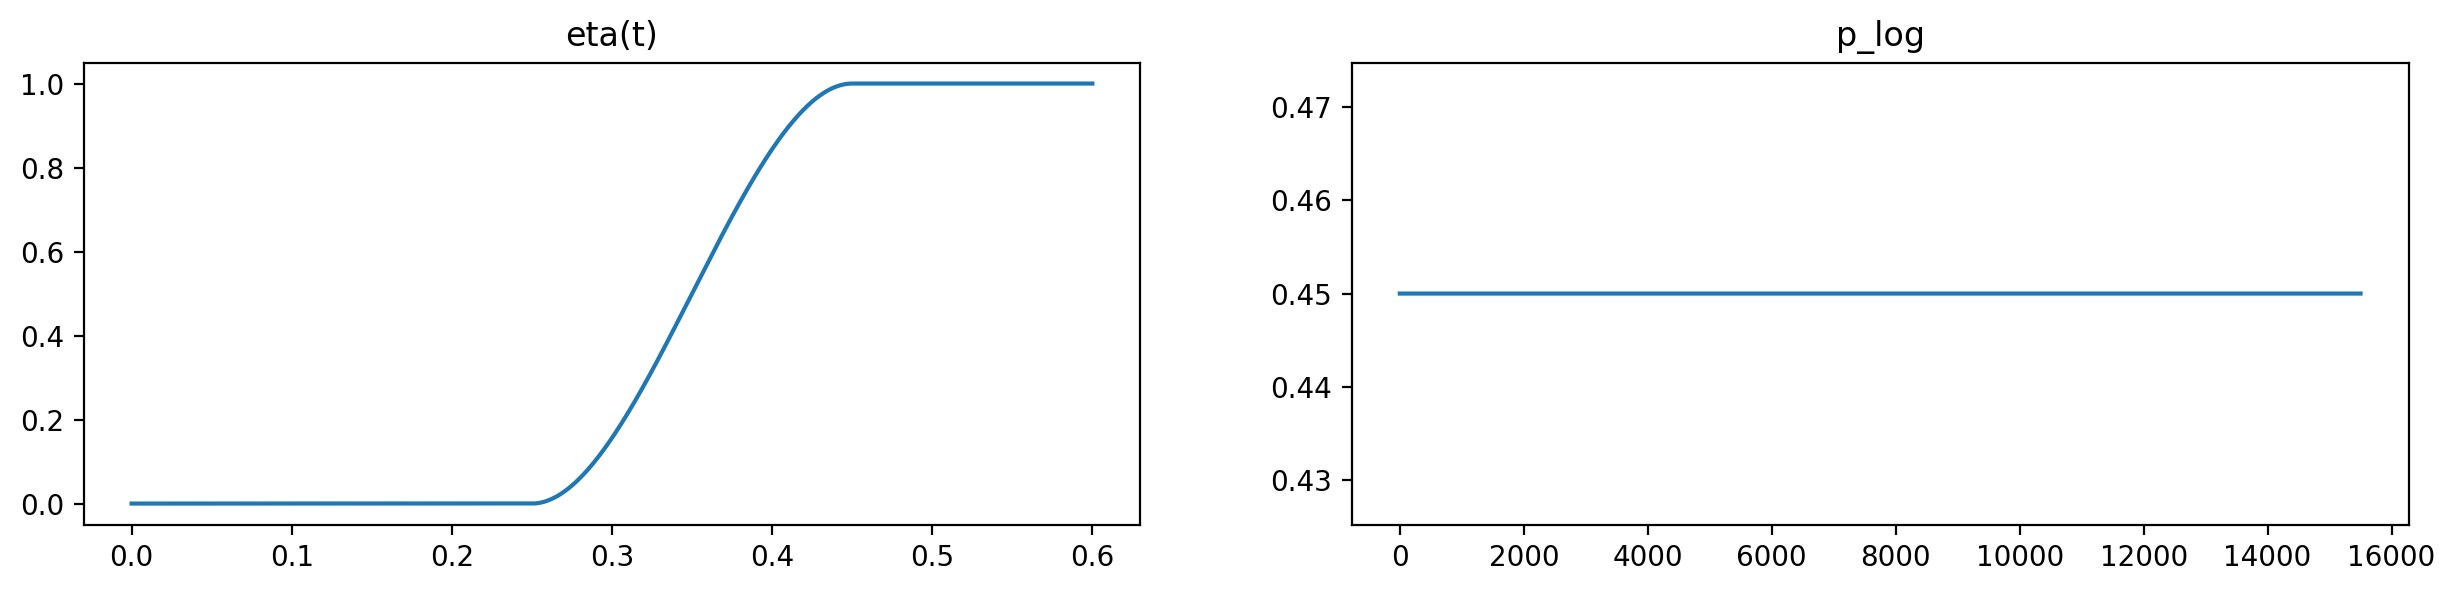

区间[0.25,0.50]的训练时间：72.32 min(s)
Final loss: 1.33031e-05,Total iteration: 15501

查看区间：[0.25,0.50]

Relative L2 error_u: 1.25343e-03

Relative L1 error_u: 5.34143e-04

Relative Linf error_u: 3.68889e-03

#小区间个数：2，总训练时长:100.38  min(s)

#查看区间[0.00,0.50]:
#error L2:1.07310e-03
#error L1:3.80256e-04
#error Linf:3.68889e-03
-----**区间个数：2, 第2次训练, 随机种子: 1000**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:1.42511e-01,i:1.83e-04,f:1.24e-01,b:1.87e-04
2000,loss:4.11708e-02,i:1.73e-05,f:3.92e-02,b:2.33e-04
3000,loss:2.58780e-02,i:1.29e-05,f:2.44e-02,b:1.93e-04
4000,loss:7.65822e-03,i:8.57e-06,f:6.77e-03,b:2.89e-05
5000,loss:4.61598e-03,i:5.67e-06,f:4.03e-03,b:1.95e-05

	====Begin LBFSG====
6000,loss:2.18831e-04,i:5.63e-07,f:1.59e-04,b:3.81e-06
7000,loss:8.38432e-05,i:1.68e-07,f:6.65e-05,b:5.95e-07
8000,loss:4.74890e-05,i:1.09e-07,f:3.61e-05,b:4.67e-07
9000,loss:3.44051e-05,i:7.43e-08,f:2.63e-05,b:6.76e-07
10000,loss:2.68943e-05,i:5.35e-08,f:2.10e-05,b:5.57e-07
11000,loss:2.20992e-05,i:4.35e

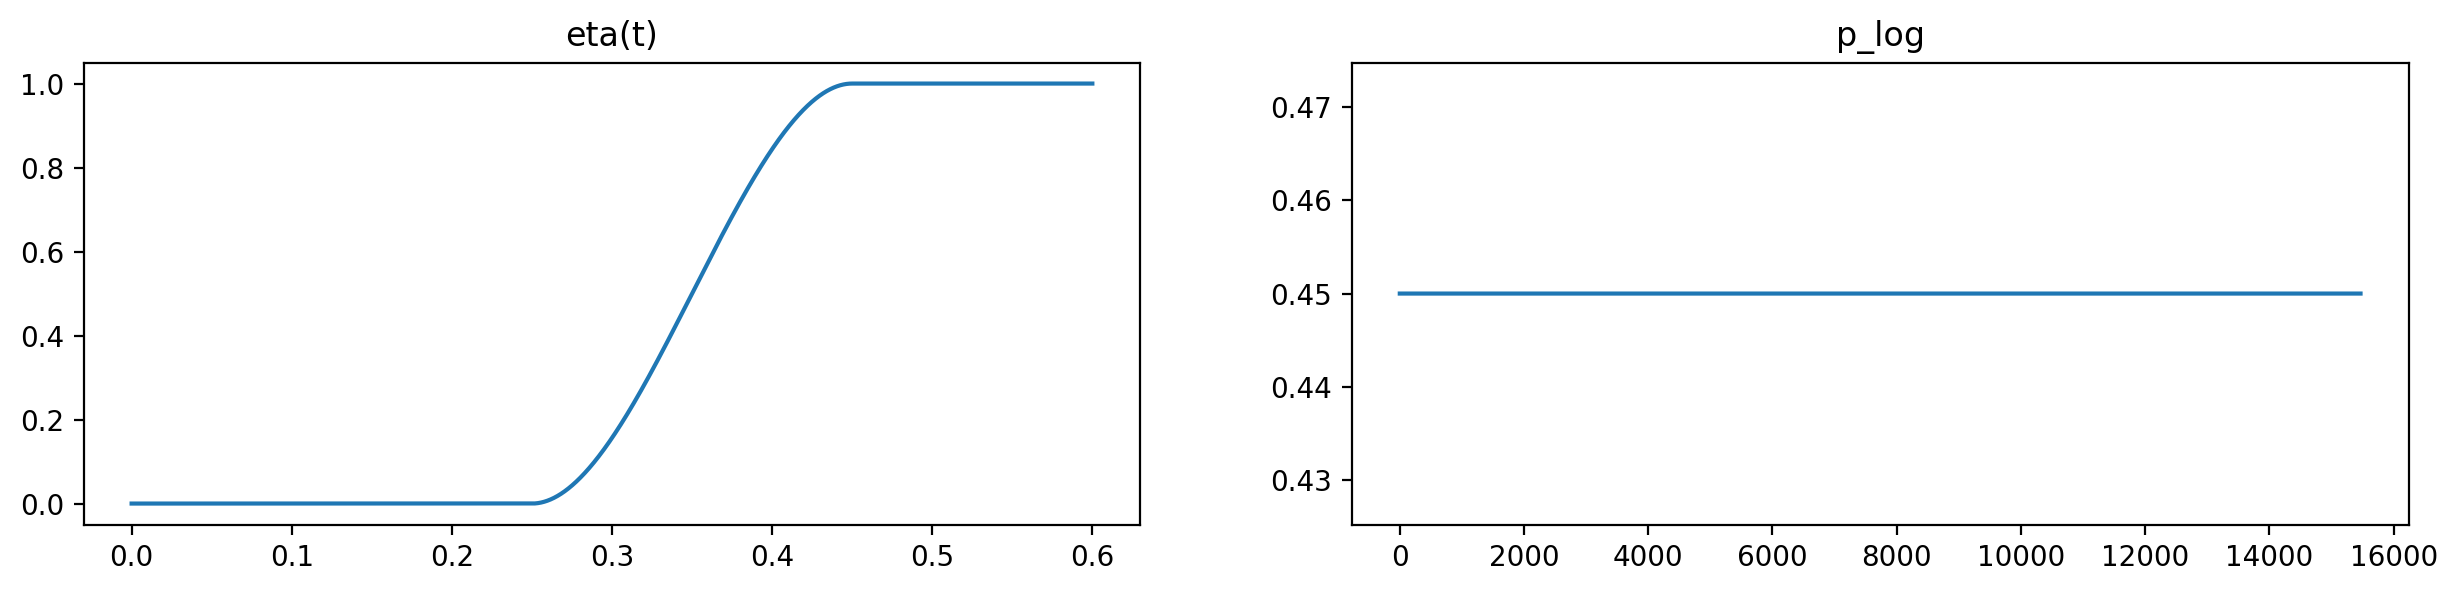

区间[0.25,0.50]的训练时间：70.08 min(s)
Final loss: 1.75217e-05,Total iteration: 15469

查看区间：[0.25,0.50]

Relative L2 error_u: 1.29945e-03

Relative L1 error_u: 5.29436e-04

Relative Linf error_u: 4.50817e-03

#小区间个数：2，总训练时长:114.39  min(s)

#查看区间[0.00,0.50]:
#error L2:1.10661e-03
#error L1:3.69862e-04
#error Linf:4.61173e-03
-----**区间个数：2, 第3次训练, 随机种子: 1500**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:3.63534e-02,i:3.96e-05,f:3.17e-02,b:6.77e-04
2000,loss:3.61475e-02,i:2.06e-05,f:1.70e-02,b:1.71e-02
3000,loss:6.13086e-03,i:8.16e-06,f:5.22e-03,b:9.09e-05
4000,loss:2.80903e-03,i:4.57e-06,f:2.33e-03,b:2.51e-05
5000,loss:2.11900e-03,i:3.12e-06,f:1.80e-03,b:8.90e-06

	====Begin LBFSG====
6000,loss:8.48899e-05,i:2.53e-07,f:5.93e-05,b:3.00e-07
7000,loss:5.09656e-05,i:9.25e-08,f:4.13e-05,b:4.02e-07
8000,loss:3.74627e-05,i:7.60e-08,f:2.96e-05,b:2.41e-07
9000,loss:2.72444e-05,i:6.46e-08,f:2.06e-05,b:1.90e-07
10000,loss:1.90694e-05,i:5.29e-08,f:1.37e-05,b:1.04e-07
11000,loss:1.45067e-05,i:4.59e

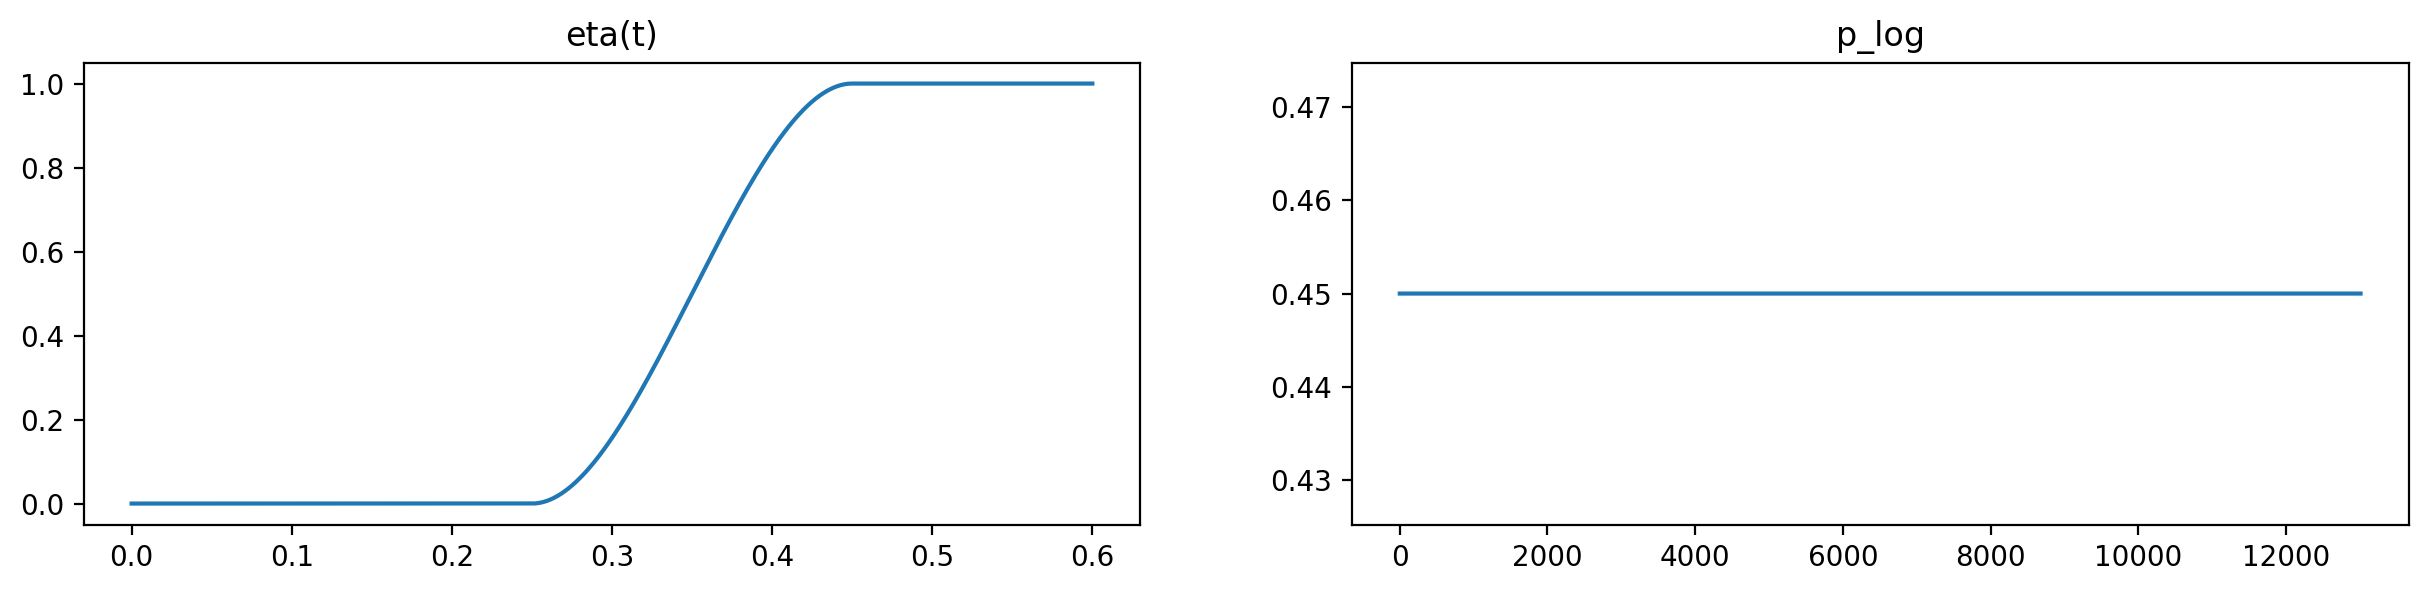

区间[0.25,0.50]的训练时间：47.75 min(s)
Final loss: 2.36758e-05,Total iteration: 13010

查看区间：[0.25,0.50]

Relative L2 error_u: 7.38912e-04

Relative L1 error_u: 3.22136e-04

Relative Linf error_u: 2.57985e-03

#小区间个数：2，总训练时长:90.17  min(s)

#查看区间[0.00,0.50]:
#error L2:6.39697e-04
#error L1:2.29112e-04
#error Linf:4.65518e-03
-----**区间个数：2, 第4次训练, 随机种子: 2000**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:5.02115e-02,i:5.09e-05,f:4.51e-02,b:6.91e-05
2000,loss:3.11495e-02,i:1.64e-05,f:2.95e-02,b:2.63e-05
3000,loss:2.15022e-02,i:1.46e-05,f:2.00e-02,b:9.18e-05
4000,loss:9.57187e-03,i:7.30e-06,f:8.77e-03,b:7.14e-05
5000,loss:5.22107e-03,i:4.14e-06,f:4.79e-03,b:1.77e-05

	====Begin LBFSG====
6000,loss:1.26901e-04,i:2.97e-07,f:9.51e-05,b:2.14e-06
7000,loss:6.51578e-05,i:1.09e-07,f:5.35e-05,b:8.41e-07
8000,loss:4.83470e-05,i:7.14e-08,f:4.08e-05,b:4.58e-07
9000,loss:3.69210e-05,i:5.44e-08,f:3.11e-05,b:4.31e-07
10000,loss:2.87821e-05,i:3.67e-08,f:2.44e-05,b:7.09e-07
11000,loss:2.25028e-05,i:3.78e-

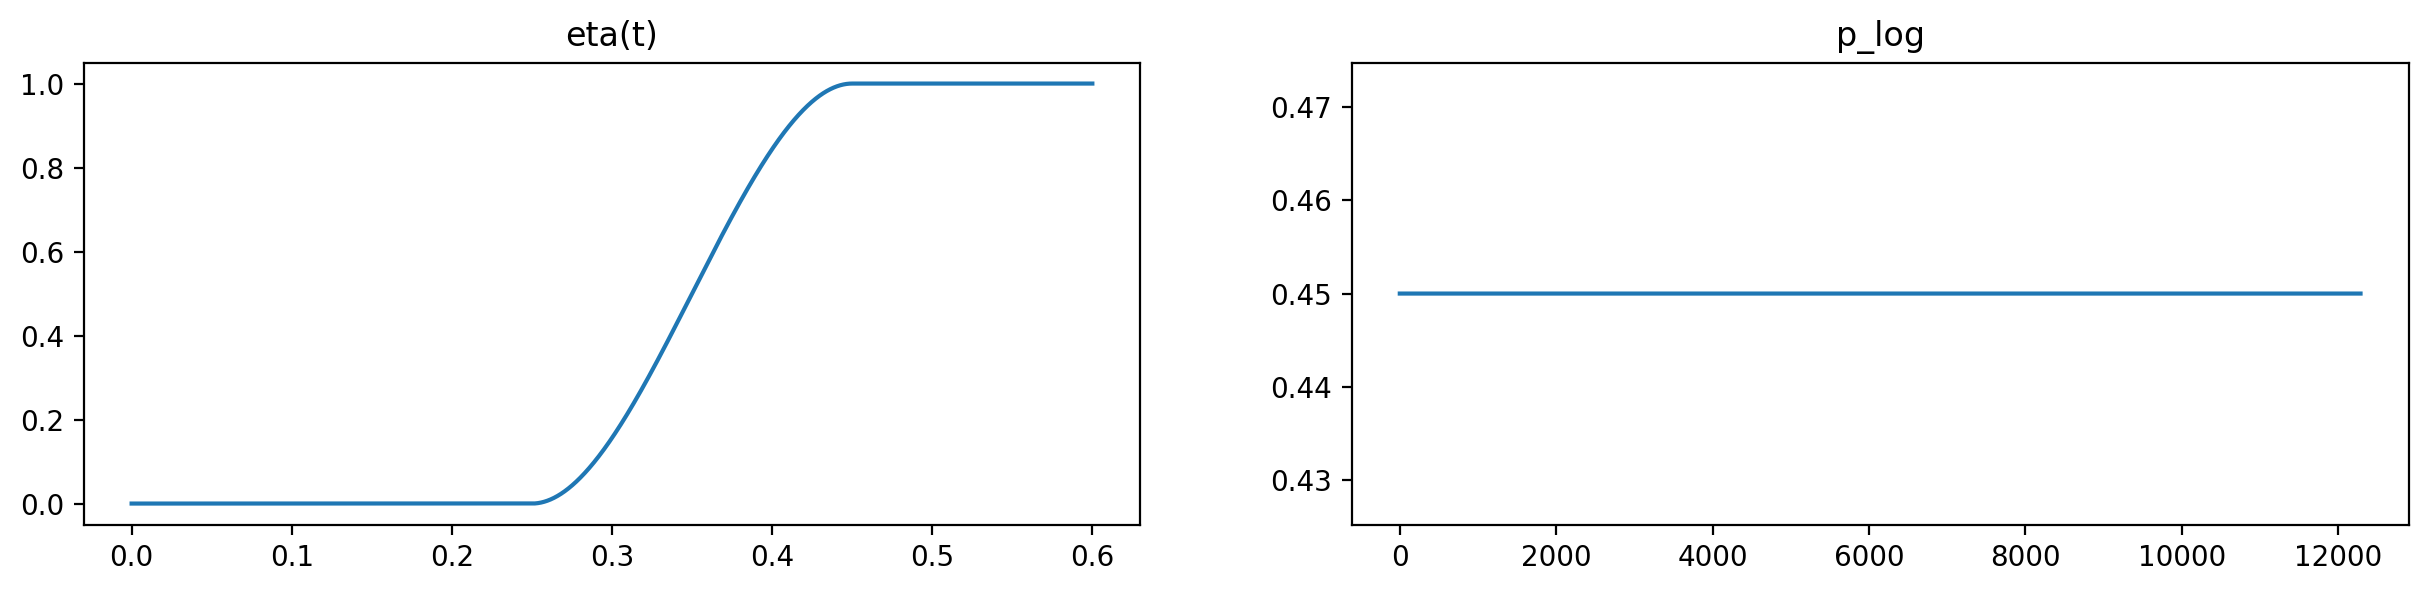

区间[0.25,0.50]的训练时间：24.78 min(s)
Final loss: 2.03078e-05,Total iteration: 12285

查看区间：[0.25,0.50]

Relative L2 error_u: 9.16881e-04

Relative L1 error_u: 3.93567e-04

Relative Linf error_u: 2.56346e-03

#小区间个数：2，总训练时长:64.08  min(s)

#查看区间[0.00,0.50]:
#error L2:7.95468e-04
#error L1:2.80312e-04
#error Linf:6.56950e-03
-----**区间个数：2, 第5次训练, 随机种子: 2500**-----
训练区间：[0.00,0.25]

	====Begin Adam====
1000,loss:4.41352e-02,i:3.87e-05,f:4.00e-02,b:2.51e-04
2000,loss:2.15896e-02,i:1.44e-05,f:1.93e-02,b:7.96e-04
3000,loss:5.63347e-03,i:8.36e-06,f:4.56e-03,b:2.35e-04
4000,loss:3.09733e-03,i:5.02e-06,f:2.55e-03,b:4.06e-05
5000,loss:2.55730e-03,i:3.79e-06,f:2.14e-03,b:3.73e-05

	====Begin LBFSG====
6000,loss:1.17566e-04,i:2.97e-07,f:8.49e-05,b:2.94e-06
7000,loss:5.63101e-05,i:1.13e-07,f:4.43e-05,b:6.69e-07
区间[0.00,0.25]的训练时间：7.75 min(s)
Final loss: 4.14575e-05,Total iteration: 7899

查看区间：[0.00,0.25]

Relative L2 error_u: 9.14977e-04

Relative L1 error_u: 3.06361e-04

Relative Linf error_u: 5.91207e-0

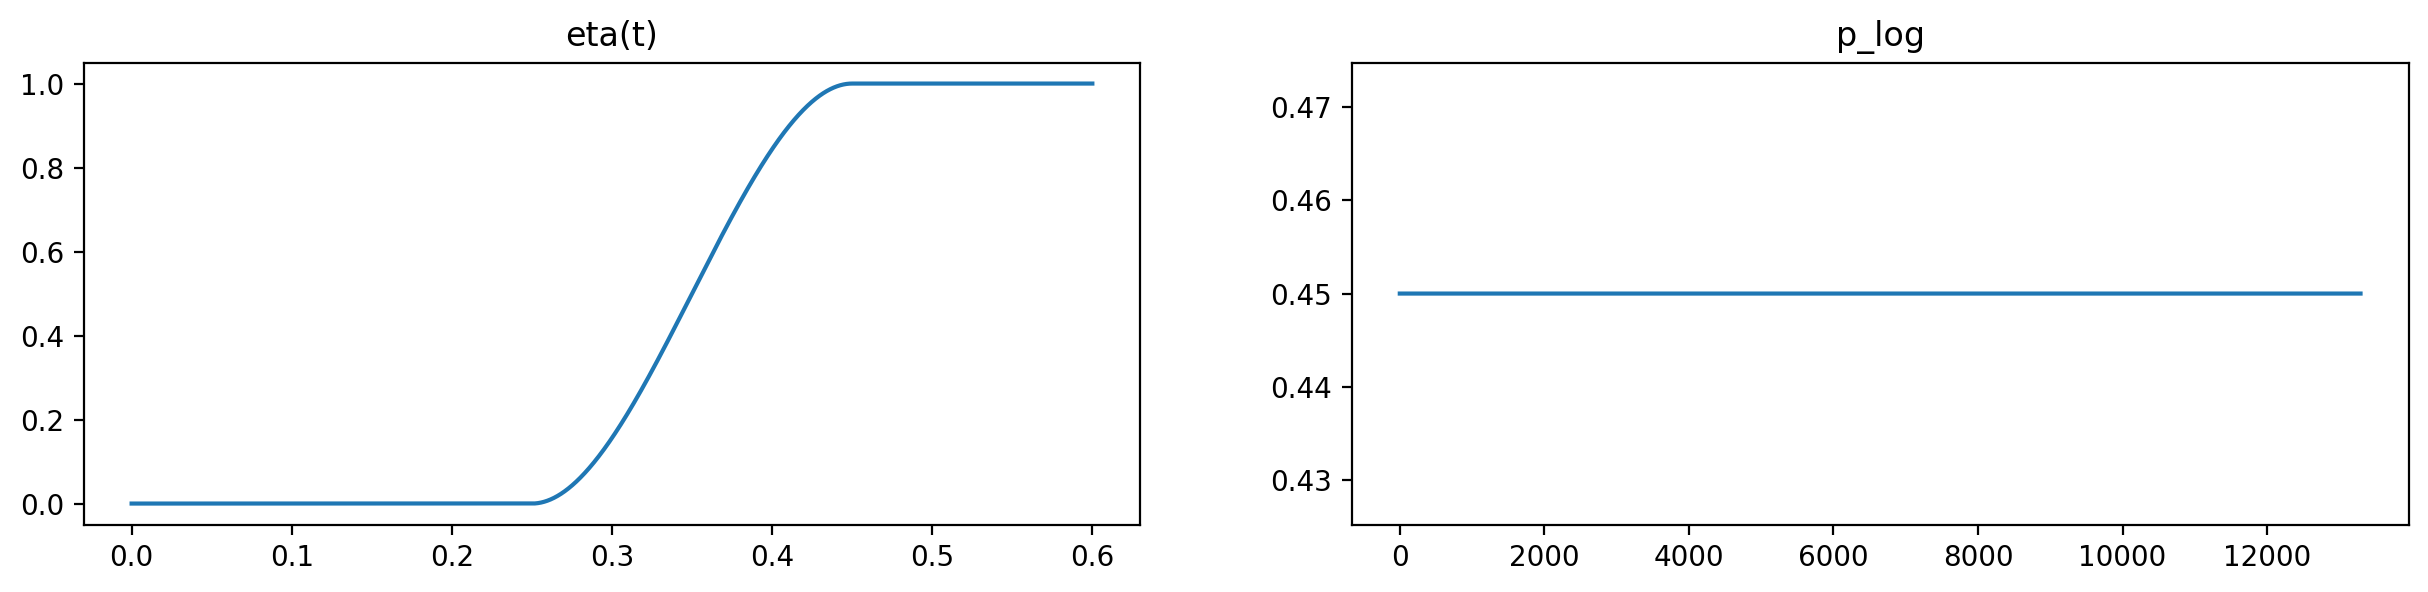

区间[0.25,0.50]的训练时间：21.67 min(s)
Final loss: 2.96268e-05,Total iteration: 13294

查看区间：[0.25,0.50]

Relative L2 error_u: 1.91820e-03

Relative L1 error_u: 7.51236e-04

Relative Linf error_u: 7.13764e-03

#小区间个数：2，总训练时长:29.41  min(s)

#查看区间[0.00,0.50]:
#error L2:1.63012e-03
#error L1:5.29349e-04
#error Linf:7.13764e-03


In [16]:



# %%



with pd.ExcelWriter(folder_path + '/error.xlsx', engine='openpyxl') as writer:
    for num in range(num_block_start, num_block_end + 1):  # 对每一个训练的区间

        error_for_train = []  # 用于记录不同区间的总误差
        Random_seed_log = []
        for train in range(1, train_times + 1):
            Random_seed = 500*train #random.randint(1, 1000 * train_times)
            Random_seed_log.append(Random_seed)
            setup_seed(Random_seed)
            print('-----**区间个数：%d, 第%d次训练, 随机种子: %d**-----' % (num, train, Random_seed))
            
           
            # 训练模型
            models, error_block, train_time = train_block(t_min, t_max, num, train)
            
            # 全区间预测
            u_pred, error_whole = u_pred_whole(models, t_min, t_max, num, train)

        

            # 完整误差记录
            error_block.append(error_whole)
            error_for_train.append(error_block)
            error_for_train.append(train_time)

        error_result = np.column_stack(error_for_train)

        # 保存结果
        column_names = [
            f"{Random_seed_log[group_num-1]}_{group_num}_{names[col_num]}"
            for group_num in range(1, train_times + 1)
            for col_num in range(0, 4)
        ]
        index_names = [f'[{t_max * i / num},{t_max * (i + 1) / num}]' for i in range(num + 1)]
        index_names[-1] = f'[{t_min},{t_max}]'
        df1 = pd.DataFrame(error_result, index=index_names, columns=column_names)
        df1.to_excel(writer, sheet_name=f'Sheet_{num}', index=True)




